This is the Code for the FKAN Project in the Biostatistics Course 2024/2025

In [1]:
#imports, just copied it from the last exercise, change as needed

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time


Loading Dataset

In [7]:
#Resizing Images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor()  # Convert images to tensors
])

# Load datasets
train_dataset = ImageFolder('chest_xray/train/', transform=transform)
valid_dataset = ImageFolder('chest_xray/val/', transform=transform)
test_dataset = ImageFolder('chest_xray/test/', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test to see if Images are loaded

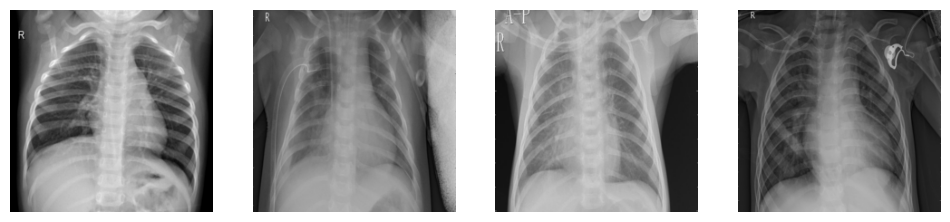

In [8]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Convert tensors to NumPy arrays and display them
images = images.numpy()  # Convert to NumPy
images = images.transpose((0, 2, 3, 1))  # Rearrange dimensions from (N, C, H, W) to (N, H, W, C)

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')  # Hide the axes
plt.show()

MLP Class Code (Taken inspiration from given Documents, errors still present)

In [ ]:
# Define the MLP model with the same depth as KAN
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p=0.5))  # Dropout with 50% probability
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def train_model(self, dataset, steps, learning_rate=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
        loss_fn = nn.CrossEntropyLoss()
        for step in range(steps):
            optimizer.zero_grad()
            outputs = self(dataset['train_input'].float())
            loss = loss_fn(outputs, dataset['train_label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

def create_dataset(loader):
    inputs = []
    labels = []
    for data in loader:
        inputs.append(data[0])
        labels.append(data[1])
    inputs = torch.cat(inputs, dim=0)
    labels = torch.cat(labels, dim=0)
    return {
        'train_input': inputs,
        'train_label': labels,
        'test_input': inputs.clone(),
        'test_label': labels.clone()
    }

def fed_avg(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for param_tensor in global_state_dict:
        global_state_dict[param_tensor].zero_()
    for client_model in client_models:
        client_state_dict = client_model.state_dict()
        for param_tensor in global_state_dict:
            global_state_dict[param_tensor] += client_state_dict[param_tensor] / len(client_models)
    global_model.load_state_dict(global_state_dict)
    return global_model

def compute_metrics(model, loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    model.training = False
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    model.training = True
    return avg_loss, accuracy, precision, recall, f1

def federated_learning_rounds(global_model, client_loaders, test_loader, rounds=rounds, steps=20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_precisions = []
    test_precisions = []
    train_recalls = []
    test_recalls = []
    train_f1s = []
    test_f1s = []

    for round_num in range(rounds):
        client_models = [copy.deepcopy(global_model) for _ in range(len(client_loaders))]
        for i, client_loader in enumerate(client_loaders):
            client_dataset = create_dataset(client_loader)
            print(f"Training client {i+1}/{len(client_loaders)}")
            if isinstance(client_models[i], KANClassifier):
                client_models[i].train_kan(client_dataset, steps, lamb=0.01, lamb_entropy=10.0)
            elif isinstance(client_models[i], MLP):
                client_models[i].train_model(client_dataset, steps)

        global_model = fed_avg(global_model, client_models)

        train_loss, train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(global_model, client_loaders[0])
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(global_model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_precisions.append(train_precision)
        test_precisions.append(test_precision)
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        print(f'Round {round_num+1} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, '
              f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
              f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}, '
              f'Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

    return global_model, train_losses, test_losses, train_accuracies, test_accuracies, train_precisions, test_precisions, train_recalls, test_recalls, train_f1s, test_f1s


NameError: name 'rounds' is not defined

Initizaling MLP

In [ ]:
# Initialize MLP model with 3 hidden layers and the same number of units as KAN
input_size = 4
hidden_sizes = [20, 20, 20]
output_size = 3
mlp_model = MLP(input_size, hidden_sizes, output_size)

# Measure the training time for MLP model
start_time = time.time()
mlp_global_model, mlp_train_losses, mlp_test_losses, mlp_train_accuracies, mlp_test_accuracies, mlp_train_precisions, mlp_test_precisions, mlp_train_recalls, mlp_test_recalls, mlp_train_f1s, mlp_test_f1s = federated_learning_rounds(
    mlp_model, client_loaders, test_loader, rounds=rounds)
mlp_training_time = time.time() - start_time
print(f"MLP model training time: {mlp_training_time:.2f} seconds")